# VIP - Vortex Image Processing package

Tutorial for *VIP 0.5.1* (2016/09/21)

Author: *Carlos Gomez Gonzalez*

## **Table of contents**

* [1. Loading ADI data](#1.-Loading-ADI-data)

* [2. Pre-processing the ADI cube](#2.-Pre-processing-the-ADI-cube)
    - [2.1. Re-centering the ADI frames](#2.1.-Re-centering-the-ADI-frames)
    - [2.2. Additional pre-processing procedures](#2.2.-Additional-pre-processing-procedures)

* [3. Signal to noise and S/N map generation](#3.-Signal-to-noise-and-S/N-map-generation)

* [4. Reference PSF generation for ADI](#4.-Reference-PSF-generation-for-ADI)
    - [4.1. ADI median subtraction](#4.1.-ADI-median-subtraction)
    - [4.2. Full-frame PCA](#4.2.-Full-frame-PCA)
        - [4.2.1. Optimizing the number of PCs for full-frame ADI PCA](#4.2.1.-Optimizing-the-number-of-PCs-for-full-frame-ADI-PCA)
        - [4.2.2. Full-frame ADI PCA with a PA rejection criterion](#4.2.2.-Full-frame-ADI-PCA-with-a-PA-rejection-criterion)
        - [4.2.3. PCA for big datacubes](#4.2.3.-PCA-for-big-datacubes)
    - [4.3. Annular PCA](#4.3.-Annular-PCA)
    - [4.4. Full-frame ADI-NMF](#4.4.-Full-frame-ADI-NMF)
    - [4.5. LLSG](#4.5.-LLSG)
 
* [5. Detection function](#5.-Detection-function)
 
* [6. Generating synthetic planets](#6.-Generating-synthetic-planets)
 
* [7. Flux and position estimation with the NEGFC](#7.-Flux-and-position-estimation-with-the-NEGFC)
    - [7.1. Nelder-Mead based optimization](#7.1.-Nelder-Mead-based-optimization)
    - [7.2. Planet subtraction](#7.2.-Planet-subtraction)
    - [7.3. NEGFC technique coupled with MCMC](#7.3.-NEGFC-technique-coupled-with-MCMC)
        - [7.3.1. Visualizing the MCMC chain: corner plots and walk plots](#7.3.1.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [7.3.2. Highly probable values and confidence intervals](#7.3.2.-Highly-probable-values-and-confidence-intervals)

* [8. Algorithmic throughput](#8.-Algorithmic-throughput)

* [9. Contrast curve generation for ADI](#9.-Contrast-curve-generation-for-ADI)


-----------

First we import vip along with other useful libraries:

In [1]:
%matplotlib inline
from matplotlib.pyplot import *
import numpy as np

import vip
plots = vip.var.pp_subplots

The alias `plots` points to a plotting function included in `VIP` (`vip.var.pp_subplots`) which is a wrapper of matplotlib functions for easy plotting and visualization of 2d and 3d arrays. `VIP` also allows working with `DS9` provided that it's installed on your system along with `XPA`. A `DS9` session (window) can be started with: 

Then the *ds9* methods will allow interact with the `DS9` window. For example, for sending an in-memory array to the `DS9` window you can use:

# 1. Loading ADI data

In the same folder where this notebook is located you can find a toy ADI (Angular Differential Imaging) cube and a NACO PSF to demostrate the capabilities of VIP. This is a L-band NACO coronagraphic (VORTEX AGPM) dataset of beta Pictoris. The sequence is heavily sub-sampled temporarily to make it smaller. Also the frames were cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

Let's inspect the fits file:

In [2]:
vip.fits.info_fits('./naco_betapic.fits')

Filename: ./naco_betapic.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   (101, 101, 61)   float32   
1                ImageHDU         7   (1, 61)      float64   


It contains a cube and its correspoding parallactic angles. An ADI sequence is acquired in pupil tracking mode, which means that the instrument field derotator remains off, thereby keeping the instrument and telescope optics aligned while the image rotates with time.


Now we load the data "in" memory with the function from the subpackage `vip.fits`:

In [3]:
psfnaco = './naco_psf.fits'
cube = './naco_betapic.fits'

cube_orig, angs = vip.fits.open_adicube(cube)
psf = vip.fits.open_fits(psfnaco)


Fits HDU:0 data successfully loaded. Data shape: [61,101,101]

Fits HDU:1 data successfully loaded. Data shape: [61]

Fits HDU:0 data successfully loaded. Data shape: [39,39]


The file is opened using `astropy` functionlity. The fits file is now a ndarray or Numpy array on memory. If you open the file (or send it to the `DS9` window) and adjust the cuts you will see the beta Pic b planet movin in a circular trajectory.

Let's measure the FWHM by fitting a 2d Gaussian to the core of the PSF:

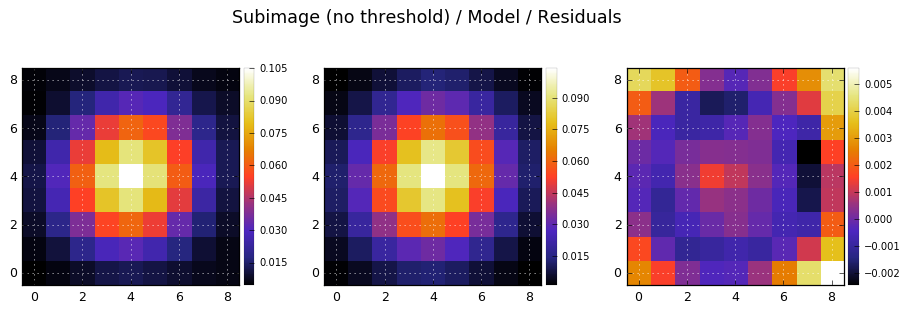

FWHM_y = 4.73321870932
FWHM_x = 4.47368242695

centroid y = [ 19.00668006]
centroid x = [ 18.99942447]
centroid y subim = [ 4.00668006]
centroid x subim = [ 3.99942447]

peak = 0.104130048421
theta = -0.594906560549


In [4]:
_ = vip.var.fit_2dgaussian(psf, crop=True, cropsize=9, debug=True)

In [5]:
fwhm_naco = np.mean([4.73, 4.47])
print fwhm_naco

4.6


Let's finally define the pixel-scale for NACO (L band), which we get from a dictionary in `vip.conf`:

In [6]:
pxscale_naco = vip.conf.VLT_NACO['plsc']
print pxscale_naco

0.02719


[Go to the top](#Table-of-contents)

# 2. Pre-processing the ADI cube

## 2.1. Re-centering the ADI frames

Subpackage `vip.calib` contains several pre-processing routines. For ADI it is critical to have the star aligned at the center of the frames, which can be particularly difficult for coronagraphic observations. Image registration is an important step for any ADI post-processing algorithm, maximizing the S/R of any potential companion.

If we take a look at one single image we will see the dark hole clearly off-center:


Done frame cropping


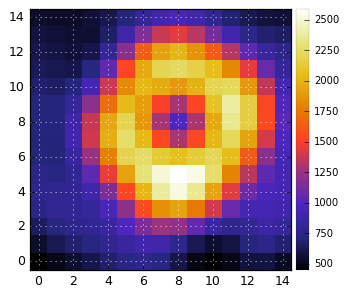

In [7]:
plots(vip.calib.frame_crop(cube_orig[0], 15), grid=True)

In `VIP` we have several recentering functions. For this ADI datset we could use either a negative 2d Gaussian fit (assuming the dark hole corresponds with the position of the star) or a fourier cross-correlation based method (using more information including the bright donut and the speckles).

In [8]:
from vip.calib import cube_recenter_gauss2d_fit, cube_recenter_dft_upsampling

For the 2d Gaussian fit it's important to run the algorithm once with the `debug` parameter set to True in order to check the results of the 2d Gaussian fit. You may need to adjust the position of the center of the structure to be fitted and the `subi_size`. When using the debug mode set `nproc` to 1 or the plots won't show up. Also try to run the debug mode in a subset of the images (a few of them) to avoid very long output.

In [9]:
cube1, shy1, shx1 = cube_recenter_gauss2d_fit(cube_orig, (51, 51), fwhm_naco, 
                                              nproc=1, subi_size=1, negative=True,
                                              full_output=True, debug=False)

----------------------------------------------------------------------
Starting time: 2016-09-21 00:58:02
----------------------------------------------------------------------
2d Gauss-fitting, looping through frames
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting the frames
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.488265
----------------------------------------------------------------------


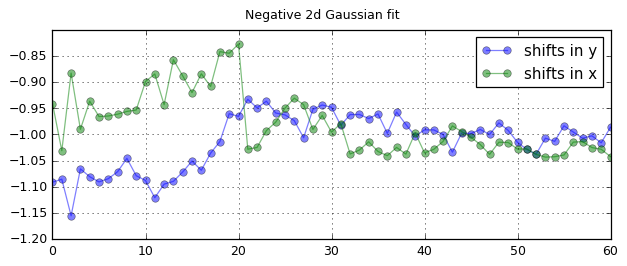

In [10]:
figure(figsize=(8,3))
plot(shy1, 'o-', label='shifts in y', alpha=0.5)
plot(shx1, 'o-', label='shifts in x', alpha=0.5)
legend(loc='best')
grid('on')
suptitle('Negative 2d Gaussian fit')

In [11]:
cube2, shy2, shx2 = cube_recenter_dft_upsampling(cube_orig, 51, 51, fwhm_naco, 
                                                 subi_size=1, full_output=True, 
                                                 debug=False)

----------------------------------------------------------------------
Starting time: 2016-09-21 00:58:04
----------------------------------------------------------------------
Looping through frames
0%                          100%
[############################# ] | ETA: 00:00:00Running time:  0:00:02.846603
----------------------------------------------------------------------


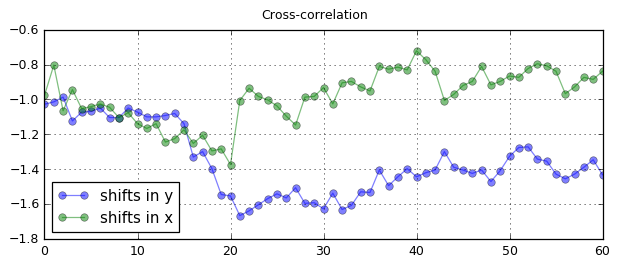

In [12]:
figure(figsize=(8,3))
plot(shy2, 'o-', label='shifts in y', alpha=0.5)
plot(shx2, 'o-', label='shifts in x', alpha=0.5)
legend(loc='best')
grid('on')
suptitle('Cross-correlation')

Frames re-centering is a case dependent procedure. For the purpose of this tutorial let's proceed with the results of the negative 2d Gaussian fit. Let's check the first frame again after the shift was applied:

In [13]:
cube = cube1

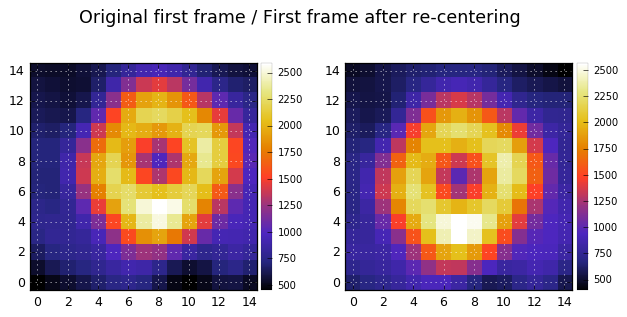

In [14]:
im1 = vip.calib.frame_crop(cube_orig[0], 15, verbose=False)
im2 = vip.calib.frame_crop(cube[0], 15, verbose=False)
plots(im1, im2, grid=True, title='Original first frame / First frame after re-centering')

For working with `VIP` the cubes must have been calibrated previously (dark/sky subtraction and flat-fielding).

For saving any results (1, 2 or 3d arrays) in FITS format use:

In [15]:
vip.fits.write_fits?

[Go to the top](#Table-of-contents)

## 2.2. Additional pre-processing procedures 

`vip.calib` includes a few bad-pixel correction routines, nan-correction function, several bad-frames detection functions as well as pixel upscaling routines. In `vip.var` are contained high and low pass filtering functions. We won't do any further pre-processing to our toy cube.

[Go to the top](#Table-of-contents)

# 3. Signal to noise and S/N map generation

Let's take a small de-tour for defining the S/N in high-contrast imaging (in the case of point-like sources). By default we adopt the definition of S/N given in Mawet el al. 2014, where it's proposed to use a two samples t-test for the problem of planet detection in the case of small sample statistics, which arise in high contrast imaging at small angles. 

The main idea is to test a given speckle against the background resolution elements (at the same angular separation or radial distance from the center):

$$S/N≡ \frac{\overline{x}_1 - \overline{x}_2}{s_2\sqrt{1+\frac{1}{n_2}}}􏰙,$$

where $\overline{x}_1$ is the flux of the tested resolution element (blue dot in the figure below), $\overline{x}_2$ and $s_2$ are the mean and empirical standard deviation of the fuxes of the background resolution elements (red dots in the figure below) and $n_2$ the number of such background resolution elements.

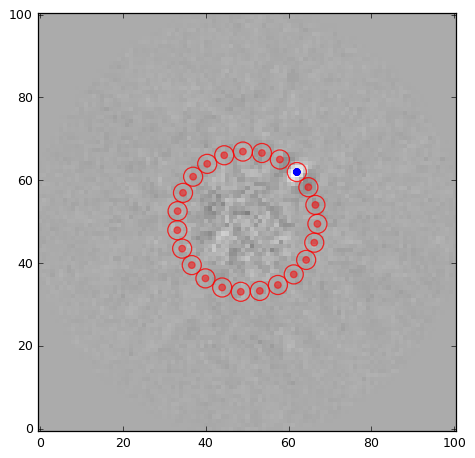

11.268421050415915

In [16]:
vip.phot.snr_ss(vip.pca.pca(cube, angs, ncomp=20, verbose=False), 
                source_xy=(62,62), fwhm=fwhm_naco, plot=True)

`VIP` also contains a function (`vip.phot.snr_peakstddev()`) for getting the S/N in a more classical way (without taking into account resolution elements but considering pixels as independent). In this case the S/N is taken as the ratio of pixel value of the planet (test speckle) and the noise computed as the standard deviation of the pixels in an annulus at the same radial distance from the center of the frame. The diameter of the signal aperture and the annulus width is in both cases 1 FWHM ~ 1 lambda/D.

The function `vip.phot.snrmap` produces an S/N map of a 2d array by computing the S/N for each pixel. It has a parameter `nproc` for exploiting multi-core systems which by default is *None*, meaning that it will get the number of physical cores available in the system.

In case we really need the S/N map of a big frame (which can take quite some time to compute depending on your hardware), a good option is to use the function `vip.phot.snrmap_fast`. It uses an approximated S/N definition that yields close results to the one mentioned earlier. 

[Go to the top](#Table-of-contents)

# 4. Reference PSF generation for ADI

## 4.1. ADI median subtraction

First thing we can try is a median subtraction approach (ADI original post-processing, Marois et al. 2006):

In [17]:
fr_adi = vip.madi.adi(cube, angs, mode='fullfr')

----------------------------------------------------------------------
Starting time: 2016-09-21 00:58:22
----------------------------------------------------------------------
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.038461
----------------------------------------------------------------------


For the annular mode, using a parallactic angle threshold:

In [18]:
fr_adi_an = vip.madi.adi(cube, angs, fwhm_naco, mode='annular')

----------------------------------------------------------------------
Starting time: 2016-09-21 00:58:23
----------------------------------------------------------------------
N annuli = 5 , FWHM = 4.6 

PA threshold 54.14 is too big, will be set to 36.61
Annulus 1, PA thresh = 36.61, Inn radius = 0.00, Ann center = 4.50 
Annulus 2, PA thresh = 19.34, Inn radius = 9.00, Ann center = 13.50 
Annulus 3, PA thresh = 11.67, Inn radius = 18.00, Ann center = 22.50 
Annulus 4, PA thresh = 8.35, Inn radius = 27.00, Ann center = 31.50 
Annulus 5, PA thresh = 6.66, Inn radius = 35.00, Ann center = 39.50 
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.114283
----------------------------------------------------------------------


*b* is clearly visible in the final frames:

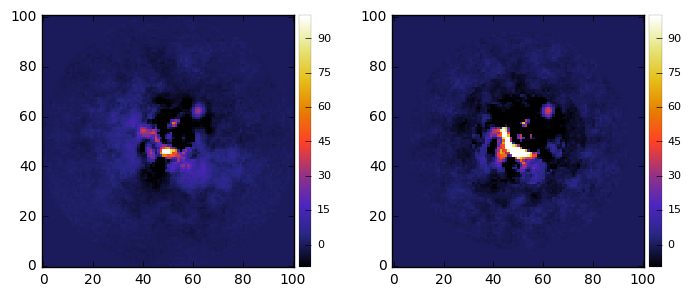

In [19]:
plots(fr_adi, fr_adi_an, rows=1, dpi=100, vmin=-10, vmax=100, colorb=True)

[Go to the top](#Table-of-contents)

## 4.2. Full-frame PCA

Now let's try the PCA based algorithms in `vip.pca`:

In [20]:
fr_pca1 = vip.pca.pca(cube, angs, ncomp=5, mask_center_px=None)

----------------------------------------------------------------------
Starting time: 2016-09-21 00:58:29
----------------------------------------------------------------------
Done vectorizing the frames. Matrix shape [61,10201]
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.043244
----------------------------------------------------------------------
Done de-rotating and combining
Running time:  0:00:00.087490
----------------------------------------------------------------------


Here we compare the median subtraction with the PCA result (on the right). The improvement is clear:

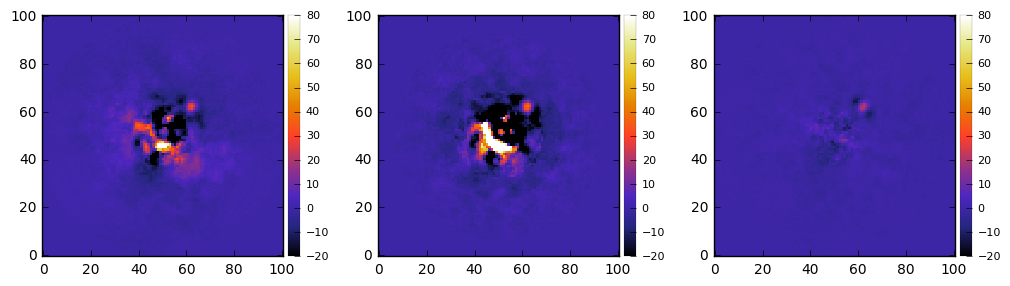

In [22]:
plots(fr_adi, fr_adi_an, fr_pca1, rows=1, dpi=100, vmin=-20, vmax=80, colorb=True)

[Go to the top](#Table-of-contents)

### 4.2.1. Optimizing the number of PCs for full-frame ADI PCA

Clearly modeling the background (leaked starlight + static and quasi-static speckles) with PCA is better than the subtraction of the median frame. We chose 5 principal componenets (PCs) and we already improved the residual noise. 

With `vip.pca.pca_optimize_snr` we find out the optimal number of PCs for this position in the field:

----------------------------------------------------------------------
Starting time: 2016-09-21 00:58:45
----------------------------------------------------------------------
Done SVD/PCA with numpy SVD (LAPACK)
Number of evaluated steps 16
Optimal number of PCs = 17, for SNR=12.189393994

Running time:  0:00:01.096678
----------------------------------------------------------------------

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 62,62
Central pixel S/N: 
S/N for the given pixel = 12.189393994
Integrated flux in FWHM test aperture = 69.945
Mean of background apertures integrated fluxes = -3.213
Std-dev of background apertures integrated fluxes = 5.870
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.460
Max S/N (shifting the aperture center) = 12.212
stddev S/NR (shifting the aperture center) = 2.706
------------------------

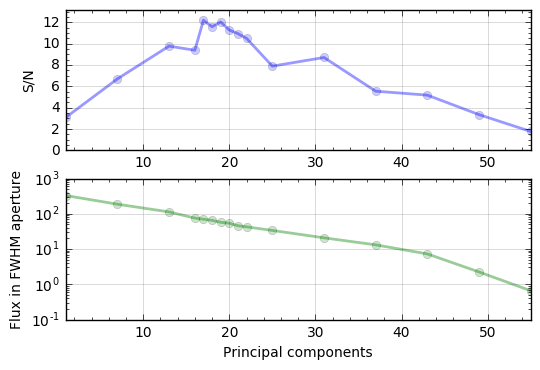

In [23]:
opt_pcs = vip.pca.pca_optimize_snr(cube, angs, fwhm=fwhm_naco, source_xy=(62,62), 
                                   mask_center_px=None, fmerit='px', 
                                   range_pcs=None)

Now let's use the 17 PCs and compute the S/N maps:

In [24]:
fr_pca2 = vip.pca.pca(cube, angs, ncomp=opt_pcs, mask_center_px=None)

----------------------------------------------------------------------
Starting time: 2016-09-21 00:58:57
----------------------------------------------------------------------
Done vectorizing the frames. Matrix shape [61,10201]
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.034664
----------------------------------------------------------------------
Done de-rotating and combining
Running time:  0:00:00.079784
----------------------------------------------------------------------


In [25]:
snrmap1 = vip.phot.snrmap(fr_pca1, fwhm_naco, plot=False)
snrmap2 = vip.phot.snrmap(fr_pca2, fwhm_naco, plot=False)

----------------------------------------------------------------------
Starting time: 2016-09-21 00:59:01
----------------------------------------------------------------------
S/N map created using 28 processes.
Running time:  0:00:04.265374
----------------------------------------------------------------------
----------------------------------------------------------------------
Starting time: 2016-09-21 00:59:05
----------------------------------------------------------------------
S/N map created using 28 processes.
Running time:  0:00:04.479514
----------------------------------------------------------------------


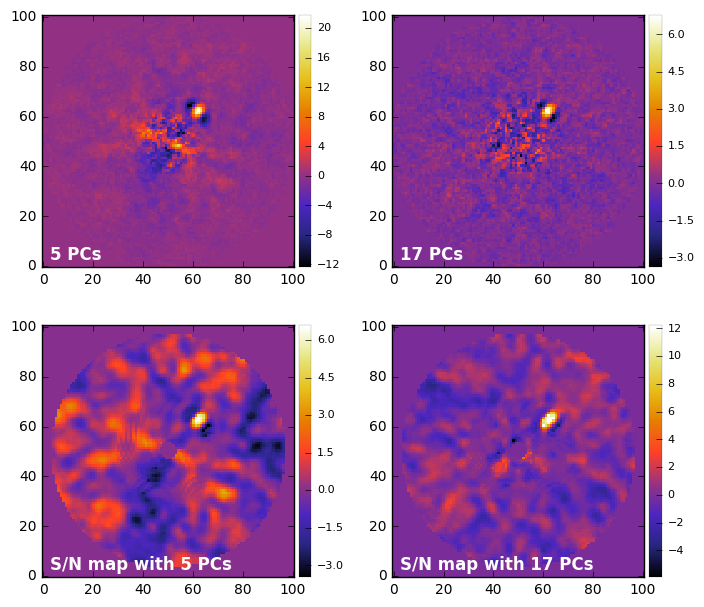

In [26]:
plots(fr_pca1, fr_pca2, snrmap1, snrmap2, rows=2, dpi=100, colorb=True, 
      label=['5 PCs', '17 PCs', 'S/N map with 5 PCs', 'S/N map with 17 PCs'], labelpad=8)

With 17 PCs we've increased the S/N but reduced also the flux from the companion.

[Go to the top](#Table-of-contents)

### 4.2.2. Full-frame ADI PCA with a PA rejection criterion

This dataset has a large range of rotation:

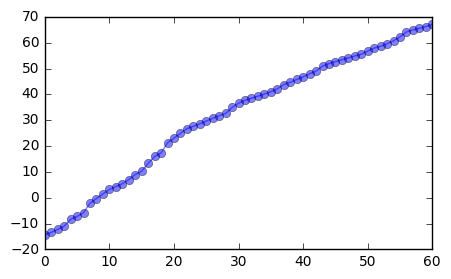

In [27]:
figure(figsize=(5,3))
plot(angs, 'o-', alpha=0.5)

We can partially avoid the companion self-subtraction with full-frame PCA by applying a PA threshold for a given distance from the center (exploiting the 80 degrees of rotation). The function `vip.pca.pca` accepts a parameter `source_xy` for defining this location and the corresponding PA threshold. The parameter `delta_rot` sets the amount of rotation in terms of the FWHM for rejecting frames from the library.

In [28]:
fr_pca_optlib = vip.pca.pca(cube, angs, ncomp=17, source_xy=(62,62),
                            delta_rot=1, fwhm=fwhm_naco)

----------------------------------------------------------------------
Starting time: 2016-09-21 00:59:17
----------------------------------------------------------------------
Size LIB: min=30.0 / 1st QU=30.0 / med=30.0 / 3rd QU=30.0 / max=30.0
Done de-rotating and combining
Running time:  0:00:00.614060
----------------------------------------------------------------------


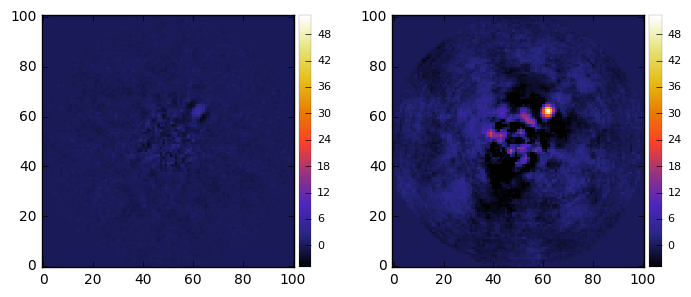

In [29]:
plots(fr_pca2, fr_pca_optlib, dpi=100, vmin=-5, vmax=fr_pca_optlib.max(), colorb=True)

We can have a quick report on the frames by choosing a position with `source_xy`:

In [30]:
_ = vip.phot.frame_quick_report(fr_pca2, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 62,62
Central pixel S/N: 
S/N for the given pixel = 12.189393994
Integrated flux in FWHM test aperture = 69.945
Mean of background apertures integrated fluxes = -3.213
Std-dev of background apertures integrated fluxes = 5.870
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.460
Max S/N (shifting the aperture center) = 12.212
stddev S/NR (shifting the aperture center) = 2.706
----------------------------------------------------------------------


In [31]:
_ = vip.phot.frame_quick_report(fr_pca_optlib, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 62,62
Central pixel S/N: 
S/N for the given pixel = 6.50783922672
Integrated flux in FWHM test aperture = 507.789
Mean of background apertures integrated fluxes = -42.671
Std-dev of background apertures integrated fluxes = 82.725
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 4.780
Max S/N (shifting the aperture center) = 6.508
stddev S/NR (shifting the aperture center) = 1.079
----------------------------------------------------------------------


The flux from the companion is 7 times larger, but the S/N has decreased due to the less smooth background at the same separation.

[Go to the top](#Table-of-contents)

### 4.2.3. PCA for big datacubes

Computing the PCA model can be a CPU and memory intensive procedure, when working with thousands of large (> 500x500) frames. This small toy cube won't let us demostrate this. In the `VIP` there will be more details about this. Check the function documentation:

In [32]:
vip.pca.pca_incremental?

[Go to the top](#Table-of-contents)

## 4.3. Annular PCA

We can exploit the range of rotation by using **local PCA** approximations and applying a PA threshold for different annuli. This is the same idea used before but the PA threshold will be adjusted depending on the distance from the star. The computational cost increases accordingly.

The function `vip.pca.pca_adi_annular` processes the cube in annular fashion (optionally in quadrants of annulus) in a serial or parallel way. The improvement in speed is noticeable in multi-core machines.

In [33]:
from vip.pca import pca_adi_annular

In [34]:
fr_pca_an15 = pca_adi_annular(cube, angs, fwhm=fwhm_naco, ncomp=15, 
                              asize=2, delta_rot=0.5, nproc=None)

----------------------------------------------------------------------
Starting time: 2016-09-21 00:59:30
----------------------------------------------------------------------
# annuli = 5, Ann width = 9, FWHM = 4.600

PCA will be done locally per annulus and per quadrant

Annulus 1, PA thresh = 28.67, Inn radius = 0.00, Ann center = 4.50 
Size LIB: min=15.0 / 1st QU=19.0 / med=24.0 / 3rd QU=31.0 / max=44.0
Done PCA with randsvd for current annulus
Running time:  0:00:00.866135
----------------------------------------------------------------------
Annulus 2, PA thresh = 9.74, Inn radius = 9.00, Ann center = 13.50 
Size LIB: min=41.0 / 1st QU=43.0 / med=46.0 / 3rd QU=50.0 / max=54.0
Done PCA with randsvd for current annulus
Running time:  0:00:02.996439
----------------------------------------------------------------------
Annulus 3, PA thresh = 5.85, Inn radius = 18.00, Ann center = 22.50 
Size LIB: min=48.0 / 1st QU=50.0 / med=52.0 / 3rd QU=54.0 / max=57.0
Done PCA with randsvd for c

The parameter `ncomp` can be set to *None* for letting the algorithm define automatically the number of PCs for each patch (instead of fixing it for all of them) by minimizing the change in the standard deviation of the  residuals after the subtraction of the PCA approximation, when increasing the PCs. This procedure is somewhat similar to LOCI. Let's try this and also work on quadrants.

In [35]:
fr_pca_quadan_auto = pca_adi_annular(cube, angs, fwhm=fwhm_naco, ncomp=None, nproc=None,
                                     asize=2, delta_rot=0.5, quad=True, tol=0.1, debug=True)

----------------------------------------------------------------------
Starting time: 2016-09-21 00:59:40
----------------------------------------------------------------------
# annuli = 5, Ann width = 9, FWHM = 4.600

PCA will be done locally per annulus and per quadrant

Annulus 1, PA thresh = 28.67, Inn radius = 0.00, Ann center = 4.50 
Size LIB: min=15.0 / 1st QU=19.0 / med=24.0 / 3rd QU=31.0 / max=44.0
Numb PCs: min=15.0 / 1st QU=18.0 / med=20.0 / 3rd QU=21.0 / max=24.0
Size LIB: min=15.0 / 1st QU=19.0 / med=24.0 / 3rd QU=31.0 / max=44.0
Numb PCs: min=15.0 / 1st QU=18.0 / med=20.0 / 3rd QU=21.0 / max=23.0
Size LIB: min=15.0 / 1st QU=19.0 / med=24.0 / 3rd QU=31.0 / max=44.0
Numb PCs: min=15.0 / 1st QU=18.0 / med=19.0 / 3rd QU=20.0 / max=22.0
Size LIB: min=15.0 / 1st QU=19.0 / med=24.0 / 3rd QU=31.0 / max=44.0
Numb PCs: min=15.0 / 1st QU=18.0 / med=19.0 / 3rd QU=21.0 / max=22.0
Done PCA with randsvd for current annulus
Running time:  0:00:03.576124
---------------------------------

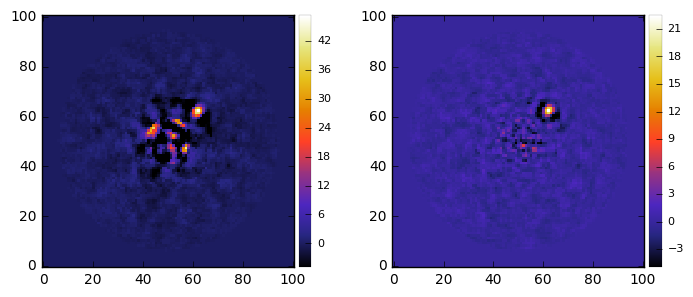

In [36]:
plots(fr_pca_an15, fr_pca_quadan_auto, dpi=100, vmin=-5, colorb=True)

In [37]:
_ = vip.phot.frame_quick_report(fr_pca_an15, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 62,62
Central pixel S/N: 
S/N for the given pixel = 8.55292984382
Integrated flux in FWHM test aperture = 421.795
Mean of background apertures integrated fluxes = -23.160
Std-dev of background apertures integrated fluxes = 50.880
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 7.448
Max S/N (shifting the aperture center) = 9.799
stddev S/NR (shifting the aperture center) = 1.896
----------------------------------------------------------------------


In [38]:
_ = vip.phot.frame_quick_report(fr_pca_quadan_auto, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 62,62
Central pixel S/N: 
S/N for the given pixel = 12.9413726665
Integrated flux in FWHM test aperture = 169.892
Mean of background apertures integrated fluxes = -5.350
Std-dev of background apertures integrated fluxes = 13.244
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 8.774
Max S/N (shifting the aperture center) = 13.506
stddev S/NR (shifting the aperture center) = 2.872
----------------------------------------------------------------------


Let's take a look at the images:

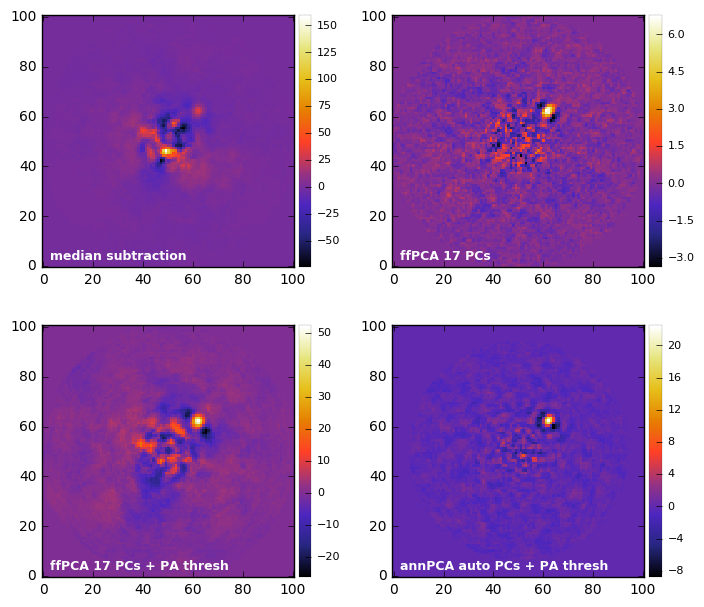

In [39]:
plots(fr_adi, fr_pca2, fr_pca_optlib, fr_pca_quadan_auto, rows=2, dpi=100, colorb=True, 
      label=['median subtraction','ffPCA 17 PCs','ffPCA 17 PCs + PA thresh',
             'annPCA auto PCs + PA thresh'], labelsize=9, labelpad=8)

[Go to the top](#Table-of-contents)

## 4.4. Full-frame ADI-NMF

A PSF reference can be modelled using a low-rank approximation different than the PCA one. Non-negative matrix factorization serves for such purpose. In `VIP's` paper there will be more details about it.

In [40]:
fr_nmf = vip.nmf.nmf(cube, angs, ncomp=20, max_iter=100, random_state=0, mask_center_px=None)

----------------------------------------------------------------------
Starting time: 2016-09-21 01:00:42
----------------------------------------------------------------------
Done vectorizing the frames. Matrix shape [61,10201]
Done NMF with sklearn.NMF.
Running time:  0:00:00.992741
----------------------------------------------------------------------
Done derotating and combining.
Running time:  0:00:01.131175
----------------------------------------------------------------------


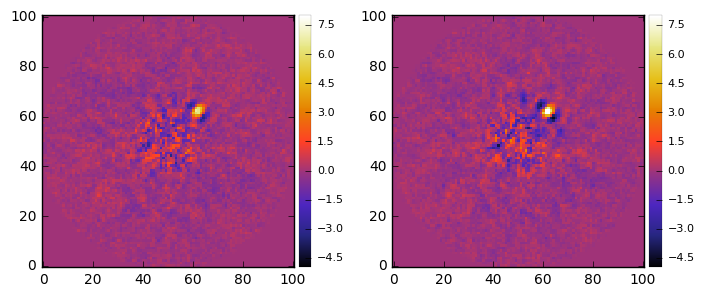

In [41]:
plots(fr_pca2, fr_nmf, dpi=100, vmin=-5, vmax=8, colorb=True)

In [42]:
_ = vip.phot.frame_quick_report(fr_nmf, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 62,62
Central pixel S/N: 
S/N for the given pixel = 8.55607793659
Integrated flux in FWHM test aperture = 80.469
Mean of background apertures integrated fluxes = -4.293
Std-dev of background apertures integrated fluxes = 9.689
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 6.354
Max S/N (shifting the aperture center) = 8.556
stddev S/NR (shifting the aperture center) = 1.980
----------------------------------------------------------------------


[Go to the top](#Table-of-contents)

## 4.5. LLSG

Local Low-rank plus Sparse plus Gaussian-noise decomposition (Gomez Gonzalez et al. 2016) proposes a three term decomposition for improving the detectability of point-like sources in ADI data. This first version of our algorithm aims at decomposing ADI cubes into L+S+G (low-rank, sparse and Gaussian noise) terms. Separating the noise from the S component (where the moving planet should stay) allow us to increase the S/N of potential planets.


Let's try it out:

In [88]:
fr_llsg = vip.llsg.llsg(cube, angs, fwhm_naco, rank=6, thresh=2.5, max_iter=20, random_seed=10)

----------------------------------------------------------------------
Starting time: 2016-09-21 01:07:21
----------------------------------------------------------------------
5 annuli, Ann width = 10, FWHM = 4.600

Running time:  0:00:00.726751
----------------------------------------------------------------------


Let's plot it along the full-frame ADI PCA result, after the optimization of the number of PCs:

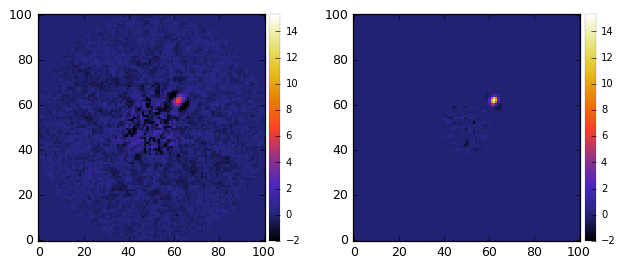

In [89]:
plots(fr_pca2, fr_llsg, vmin=-2, vmax=fr_llsg.max(), colorb=True)

In [90]:
_ = vip.phot.frame_quick_report(fr_llsg, fwhm=fwhm_naco, source_xy=(62,62))

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 62,62
Central pixel S/N: 
S/N for the given pixel = 122.378500647
Integrated flux in FWHM test aperture = 108.112
Mean of background apertures integrated fluxes = -0.255
Std-dev of background apertures integrated fluxes = 0.866
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 131.854
Max S/N (shifting the aperture center) = 389.781
stddev S/NR (shifting the aperture center) = 101.299
----------------------------------------------------------------------


A S/N map when the noise has been almost totally supressed becomes problematic, but nevertheless let's compute it:

----------------------------------------------------------------------
Starting time: 2016-09-21 01:07:25
----------------------------------------------------------------------


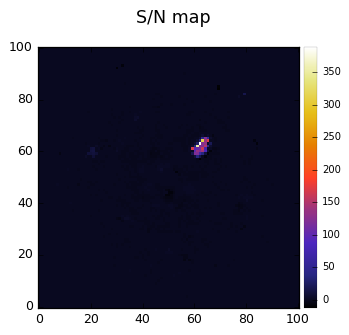

S/N map created using 28 processes.
Running time:  0:00:01.286673
----------------------------------------------------------------------


In [91]:
snrmap_llsg = vip.phot.snrmap(fr_llsg, fwhm_naco, plot=True)

[Go to the top](#Table-of-contents)

# 5. Detection function

Let's try the detection module, providing the processed frame, the FWHM in pixels and a PSF (what the planet should look like). Take a look at the help/docstring for an detailed explanation of the function. Depending on the `mode` the results can be different. As a final step a S/N minimum criterion can be checked, with `snr_thresh`.

We'll try a computer vision blob-detection method, the Laplacian of Gaussian filter (http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log) on the median subtracted frame and the annular PCA.

FWHM = 4.80097325514

Blobs found: 5
 ycen   xcen
------ ------
54.986 	 52.955
54.864 	 59.493
63.258 	 51.233
66.992 	 62.334
71.928 	 71.868
----------------------------------------------------------------------
X,Y = (43.0,45.0)
S/N constraint NOT fulfilled (S/N = 1.120)
----------------------------------------------------------------------
X,Y = (49.5,44.9)
S/N constraint NOT fulfilled (S/N = 3.401)
----------------------------------------------------------------------
X,Y = (41.2,53.3)
S/N constraint NOT fulfilled (S/N = 1.686)
----------------------------------------------------------------------
X,Y = (52.3,57.0)
S/N constraint NOT fulfilled (S/N = 0.307)
----------------------------------------------------------------------
X,Y = (61.9,61.9)
S/N constraint NOT fulfilled (S/N = 2.250)

----------------------------------------------------------------------
Input frame showing all the detected blobs / potential sources:
In RED circles those that did not pass the SNR and 2dGaussia

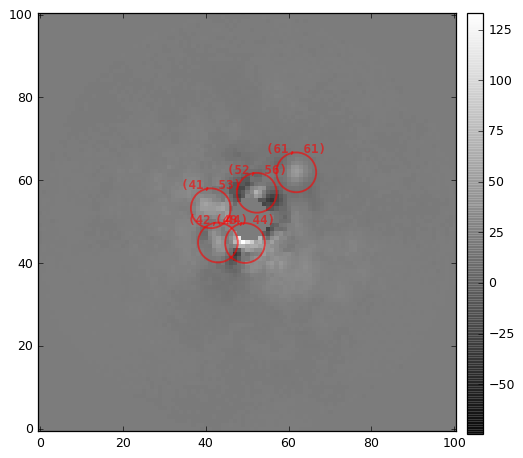

(array([], dtype=float64), array([], dtype=float64))

In [98]:
vip.phot.detection(fr_adi, psf, debug=False, mode='log', snr_thresh=5, 
                   bkg_sigma=3, matched_filter=False)

Planet *b* is highlighted but with rather small S/N (~2). We can try the frame obtained with the annular PCA:

FWHM = 4.80097325514

Blobs found: 3
 ycen   xcen
------ ------
63.699 	 54.669
72.074 	 72.086
79.365 	 68.713
----------------------------------------------------------------------
X,Y = (44.7,53.7)
S/N constraint NOT fulfilled (S/N = 3.235)
----------------------------------------------------------------------
X,Y = (62.1,62.1)


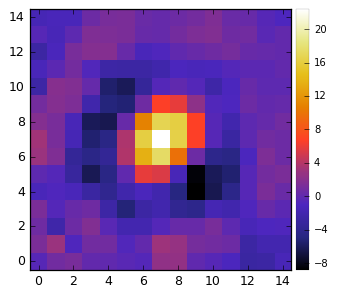

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 62.0861272721,62.0744257963
Central pixel S/N: 
S/N for the given pixel = 14.3338890298
Integrated flux in FWHM test aperture = 175.209
Mean of background apertures integrated fluxes = -4.322
Std-dev of background apertures integrated fluxes = 12.237
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.329
Max S/N (shifting the aperture center) = 15.275
stddev S/NR (shifting the aperture center) = 3.066
----------------------------------------------------------------------
----------------------------------------------------------------------
X,Y = (58.7,69.4)
S/N constraint NOT fulfilled (S/N = 0.921)

----------------------------------------------------------------------
Input frame showing all the detected blobs / potential sources:
In RED circles those that did not pass the SNR and 2dGa

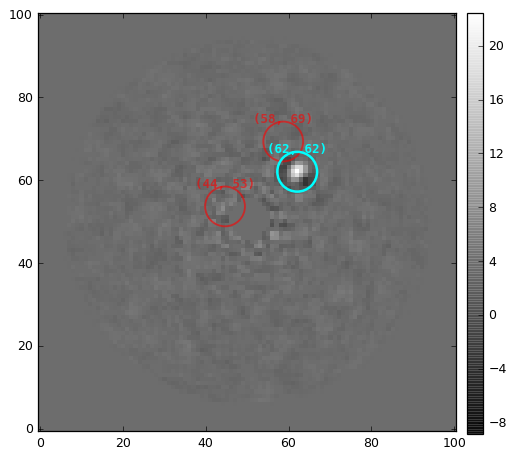

(array([ 62.0744258]), array([ 62.08612727]))

In [99]:
vip.phot.detection(fr_pca_quadan_auto, psf, bkg_sigma=3, debug=False, mode='log', 
                   snr_thresh=5, plot=True, verbose=True)

[Go to the top](#Table-of-contents)

# 6. Generating synthetic planets

With `VIP` we can we can inject fake companions with an arbitrary flux using the normalized PSF. Other procedures, e.g. the negative fake companion technique and the contrast curve generation, rely on the injection of fake companions.

In [100]:
from vip.phot import inject_fcs_cube

In [114]:
cubefc = inject_fcs_cube(cube, psf, angs, flevel=400, plsc=pxscale_naco, 
                         rad_dists=[10], theta=240, n_branches=1)

Branch 1:
	(X,Y)=(45.00, 41.34) at 0.27 arcsec (10.00 pxs)


Let's optimize the S/N with full-frame ADI PCA at this position:

----------------------------------------------------------------------
Starting time: 2016-09-21 01:21:22
----------------------------------------------------------------------
Done SVD/PCA with numpy SVD (LAPACK)
Number of evaluated steps 11
Optimal number of PCs = 17, for SNR=2.90557334636

Running time:  0:00:02.552034
----------------------------------------------------------------------

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 45,41
Central pixel S/N: 
S/N for the given pixel = 3.50953173223
Integrated flux in FWHM test aperture = 26.239
Mean of background apertures integrated fluxes = -0.155
Std-dev of background apertures integrated fluxes = 7.226
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 2.906
Max S/N (shifting the aperture center) = 6.961
stddev S/NR (shifting the aperture center) = 2.074
-----------------------

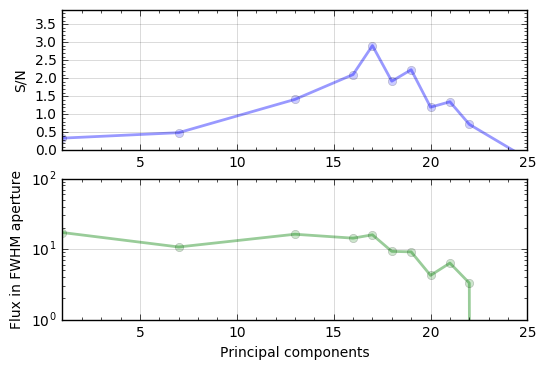

In [115]:
opt_pcs2 = vip.pca.pca_optimize_snr(cubefc, angs, fwhm=fwhm_naco, source_xy=(45,41), 
                                   mask_center_px=None, fmerit='mean', range_pcs=None)

In [116]:
fr_pca3 = vip.pca.pca(cubefc, angs, ncomp=opt_pcs2)

----------------------------------------------------------------------
Starting time: 2016-09-21 01:21:30
----------------------------------------------------------------------
Done vectorizing the frames. Matrix shape [61,10201]
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.034561
----------------------------------------------------------------------
Done de-rotating and combining
Running time:  0:00:00.076144
----------------------------------------------------------------------


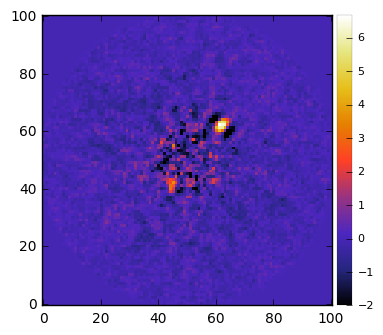

In [117]:
plots(fr_pca3, dpi=100, vmin=-2, colorb=True)

In [119]:
_ = vip.phot.frame_quick_report(fr_pca3, fwhm=fwhm_naco, source_xy=(45,41))

----------------------------------------------------------------------
Coordinates of chosen px (X,Y) = 45,41
Central pixel S/N: 
S/N for the given pixel = 3.50953173223
Integrated flux in FWHM test aperture = 26.239
Mean of background apertures integrated fluxes = -0.155
Std-dev of background apertures integrated fluxes = 7.226
----------------------------------------------------------------------
Inside 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 2.906
Max S/N (shifting the aperture center) = 6.961
stddev S/NR (shifting the aperture center) = 2.074
----------------------------------------------------------------------


[Go to the top](#Table-of-contents)

# 7. Flux and position estimation with the NEGFC

`VIP` implement the Negative fake companion technique for point-like sources position and flux estimation. It follows this steps:


- Estimate the biased position and flux of the planet from the first reduced image.
- Use the measured off-axis PSF as a template to remove the first estimate from the cleaned data cube.
- Process the cube with PCA.
- Iterate on the position and flux until a well-chosen function of merit is minimized.  
        
$chi^2 = sum(|I_j|),$ where $j \in {1,...,N}$ and $N$ the total number of pixels contained in a circular aperture (4xFWHM).

[Go to the top](#Table-of-contents)

## 7.1. Nelder-Mead based optimization

With the funciton `vip.negfc.firstguess` we can obtain a first estimation of the flux and position by running a grid naive minimization and a Nelder-mead based minimization. Initially a naive minimization of the chi^2 by trying a grid of values for the flux (parameter `f_range`). If the parameter `simplex` is set to *True* then a Nelder-Mead (simplex) minimization is done based on the preliminary guess of the naive minimization. The maximum number of iterations and error can be set with the  parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

In [120]:
from vip.negfc import firstguess

Fisrt we define the position of the sources by examining a flux frame or S/N map. `source_xy` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)).

In [121]:
source_xy = [(62,62)]


************************************************************
             Planet 0           
************************************************************

Planet 0: flux estimation at the position [62,62], running ...
Step | flux    | chi2r
1/10   400.000   0.634
2/10   466.667   0.579
3/10   533.333   0.543
4/10   600.000   0.538
5/10   666.667   0.565
6/10   733.333   0.620
7/10   800.000   0.669


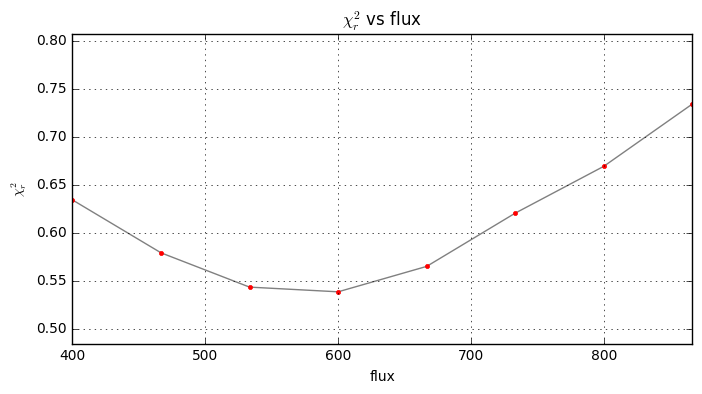

Planet 0: preliminary guess: (r,theta,f)=(16.3, 45.0, 600.0)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 39, nfev: 85, chi2r: 0.48708054115
message: Optimization terminated successfully.
Planet 0: simplex guess: (r_0,theta_0,f_0)=(16.583, 44.721, 585.577) at (X,Y)=(61.78, 61.67)

************************************************************
DONE !
************************************************************


In [122]:
r_0, theta_0, f_0 = firstguess(cube, angs, psf, ncomp=10, plsc=pxscale_naco,
                               planets_xy_coord=source_xy, fwhm=fwhm_naco, 
                               f_range=np.linspace(400,1000,10), 
                               simplex=True, display=True, verbose=True)

Nelder-Mead converged.

[Go to the top](#Table-of-contents)

## 7.2. Planet subtraction

Let's use the values obtained with the simplex optimization at try to subtract the planet with the function `vip.negfc.cube_planet_free`.

In [123]:
from vip.negfc import cube_planet_free

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [124]:
plpar_bpicb = [(r_0, theta_0, f_0)]

In [125]:
cube_emp = cube_planet_free(plpar_bpicb, cube, angs, psf, pxscale_naco)

In [126]:
fr_pca_emp = vip.pca.pca(cube_emp, angs, ncomp=opt_pcs, verbose=False)

Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

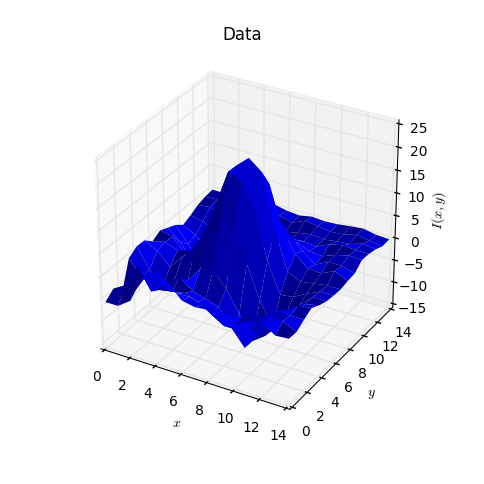

In [127]:
vip.var.plot_surface(fr_pca1, center=(62,62), size=15)

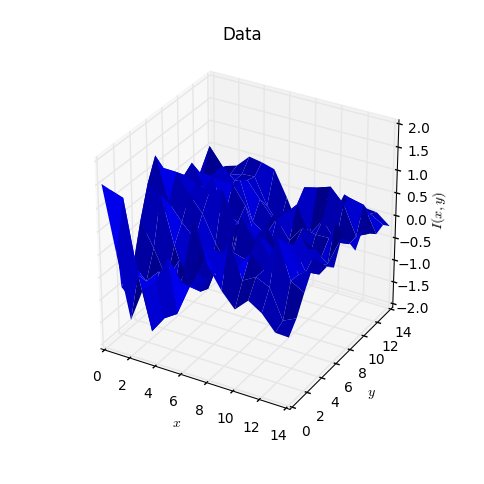

In [128]:
vip.var.plot_surface(fr_pca_emp, center=(62,62), size=15)

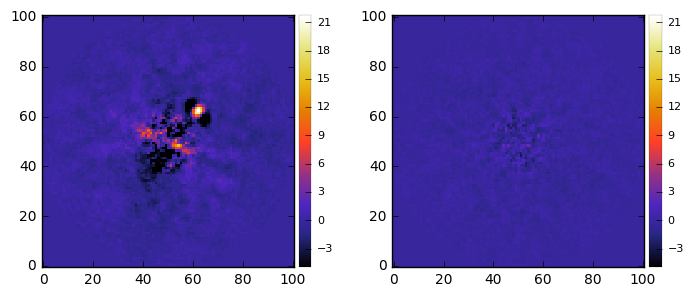

In [132]:
plots(fr_pca1, fr_pca_emp, dpi=100, vmin=-5, vmax=fr_pca1.max(), colorb=True)

[Go to the top](#Table-of-contents)

## 7.3. NEGFC technique coupled with MCMC

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can generate proper error bars. With parameter `initialState` we set the initial first estimation of the planets parameters (r, theta, flux). We can grabe the result of the simplex optimization.

In [133]:
initialState = np.array([16.3, 45.0, 600.0])

MCMC is a very CPU intensive procedure. We use the affine invariante sampler from `emcee` which can be run in parallel. At least 100 walkers are needed for convergence on our MCMC chain, but it's a case dependent parameter.

In [134]:
nwalkers, itermin, itermax = (100,100,400)

In [135]:
from vip.negfc import run_mcmc_astrometry

In [137]:
chain = run_mcmc_astrometry(cube, angs, psf, ncomp=opt_pcs, plsc=pxscale_naco,                                
                            fwhm=fwhm_naco, svd_mode='lapack',
                            initialState=initialState, nwalkers=nwalkers, 
                            bounds=None, niteration_min=itermin, 
                            niteration_limit=itermax, check_maxgap=50, nproc=10,
                            display=False, verbose=False, save=False)

... ==> convergence reached
We break the loop because we have reached convergence


Saved results, can be loaded from disk like this:

[Go to the top](#Table-of-contents)

### 7.3.1. Visualizing the MCMC chain: corner plots and walk plots 

Due to the small number of walkers and iterations convergence was not achieved.

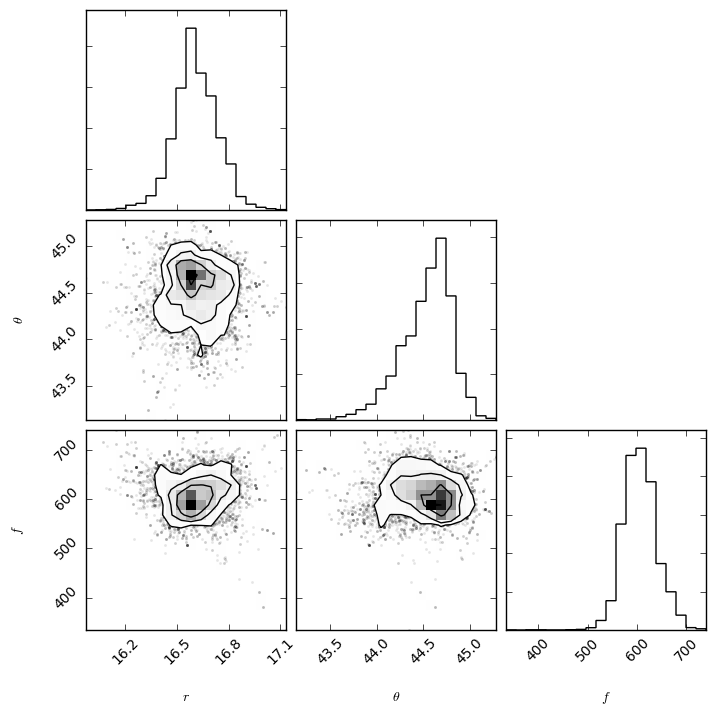

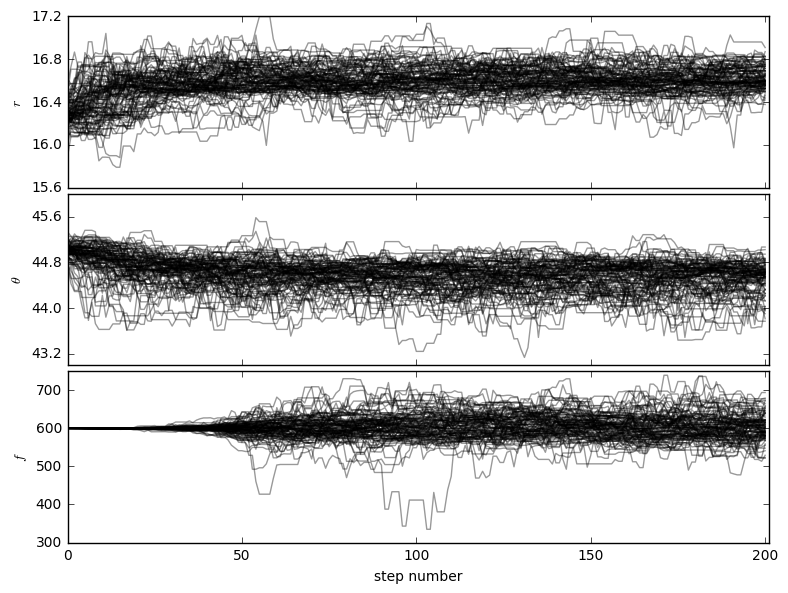

In [138]:
vip.negfc.showPDFCorner(chain)
vip.negfc.showWalk(chain)

[Go to the top](#Table-of-contents)

### 7.3.2. Highly probable values and confidence intervals 

For determining the most highly probable value for each model parameter, as well as the 1-sigma confidence interval:

percentage for r: 69.8723404255%
percentage for theta: 68.134751773%
percentage for flux: 68.1489361702%

Confidence intervals:
r: 16.5808375246 [-0.110387373804,0.168485991595]
theta: 44.6491340806 [-0.290386468368,0.204346033296]
flux: 599.848178626 [-30.3571779329,30.3571779329]

Gaussian fit results:
r: 16.6075188423 +-0.127205769432
theta: 44.5409892809 +-0.265476094745
f: 605.223919 +-34.0369126006


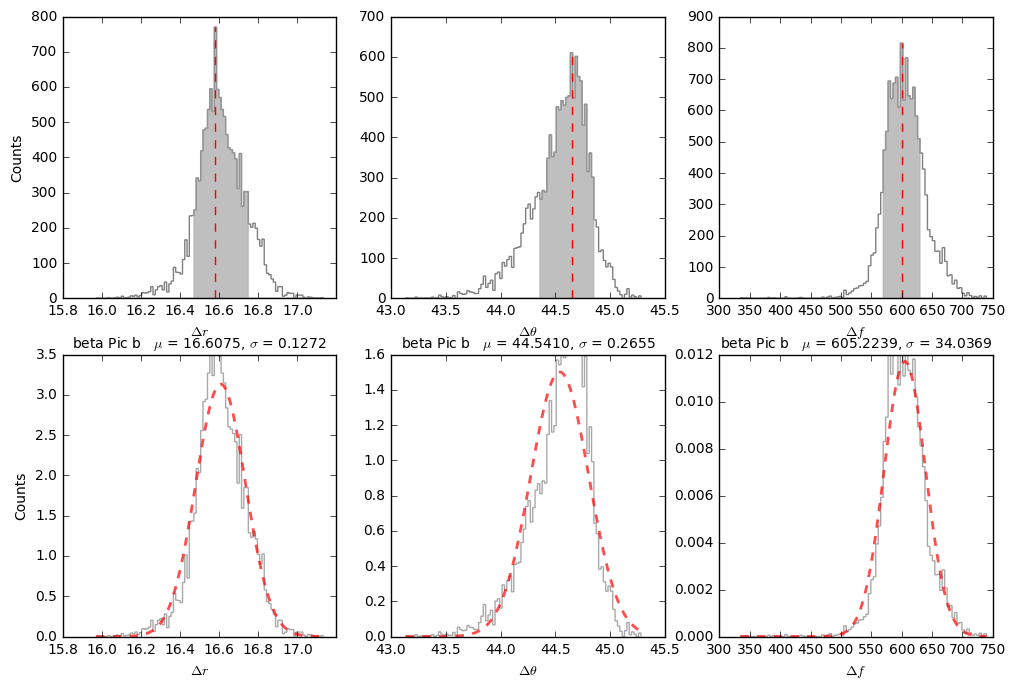

In [151]:
from vip.negfc import confidence

burnin = 0.3
isamples_flat = chain[:,chain.shape[1]//(1/burnin):,:].reshape((-1,3))

val_max, conf = confidence(isamples_flat, cfd=68, gaussianFit=True, 
                           verbose=True, save=False, title='beta Pic b')

The result we need is the mean and sigma from the parameters PDF Gaussian fit.

[Go to the top](#Table-of-contents)

# 8. Algorithmic throughput

`VIP` allows to measure the throughput of its algorithms by injectin fake companions. That will give us an idea of how much they subtract or bias the signal from companions as a function of the distance from the center. We'll use `vip.phot.throughput`. This function requires an empty cube, for avoiding messing up with the throughput curve (due to the presence of a companion). Let's use the cube with the planet subtracted that we generated in the previous steps.

In [159]:
res_thr = vip.phot.throughput(cube_emp, angs, psf, fwhm_naco, pxscale_naco, 
                              ncomp=15, algo=vip.pca.pca, nbranch=1, 
                              full_output=True)

----------------------------------------------------------------------
Starting time: 2016-09-21 02:41:42
----------------------------------------------------------------------
Cube without fake companions processed with pca
Running time:  0:00:00.071067
----------------------------------------------------------------------
Measured annulus-wise noise in resulting frame
Running time:  0:00:00.159301
----------------------------------------------------------------------
Fake companions injected in branch 1 (pattern 1/3)
Running time:  0:00:00.250685
----------------------------------------------------------------------
Cube with fake companions processed with pca
Measuring its annulus-wise throughput
Running time:  0:00:00.308674
----------------------------------------------------------------------
Fake companions injected in branch 1 (pattern 2/3)
Running time:  0:00:00.411468
----------------------------------------------------------------------
Cube with fake companions processed wi

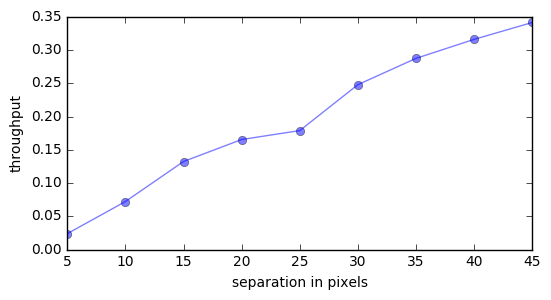

In [160]:
figure(figsize=(6,3))
plot(res_thr[2], res_thr[0][0,:], 'o-', alpha=0.5)
ylabel('throughput')
xlabel('separation in pixels')
legend()

Let's compare this with the annular PCA result:

In [158]:
res_thr2 = vip.phot.throughput(cube_emp, angs, psf, fwhm_naco, pxscale_naco, 
                               algo=vip.pca.pca_adi_annular, nbranch=1, verbose=False,
                               full_output=True, ncomp=15, delta_rot=0.5, min_frames_pca=10, 
                               svd_mode='randsvd', asize=2)

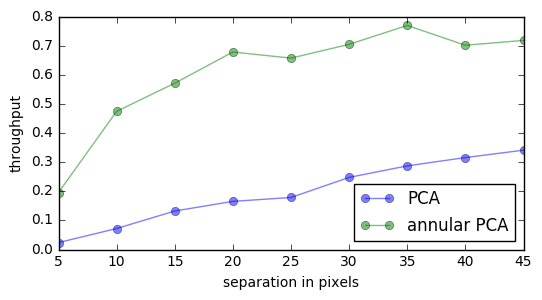

In [162]:
figure(figsize=(6,3))
plot(res_thr[2], res_thr[0][0,:], 'o-', label='PCA', alpha=0.5)
plot(res_thr2[2], res_thr2[0][0,:], 'o-', label='annular PCA', alpha=0.5)
ylabel('throughput')
xlabel('separation in pixels')
legend(loc='best')

We clearly see the gain in throughput by applying a parallactic angle rejection in our annular PCA processing. Here the `delta_rot` or amount of minimum rotation was decreased due the small number of frames, but increasing it to 1 or 1.5 (with a normal, bigger cube) will lead to better throughput.

[Go to the top](#Table-of-contents)

# 9. Contrast curve generation for ADI

Now let's see how to generate 5-sigma contrast curves for ADI PCA using `vip.phot.contrast_curve`. Parameter `Starphot` sets the flux of the star (aperture photometry of the non-coronagraphic PSF before normalization).

In [163]:
starphot = 764939.6

----------------------------------------------------------------------
Starting time: 2016-09-21 02:44:33
----------------------------------------------------------------------
Finished the throughput calculation
Running time:  0:00:00.565815
----------------------------------------------------------------------
SIGMA = 5
STARPHOT = 764939.6


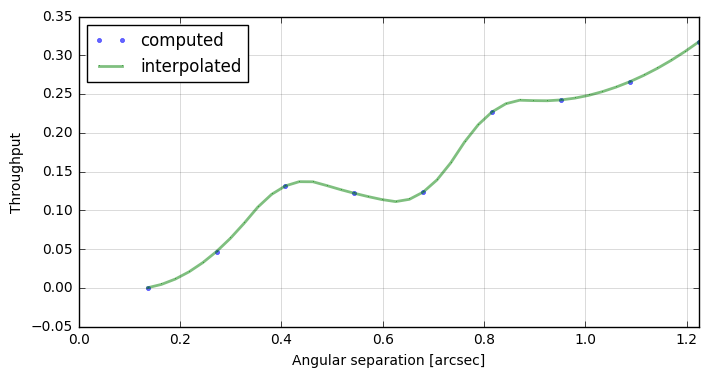

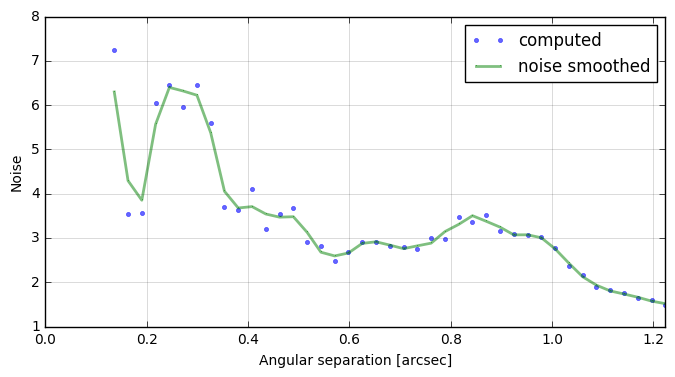

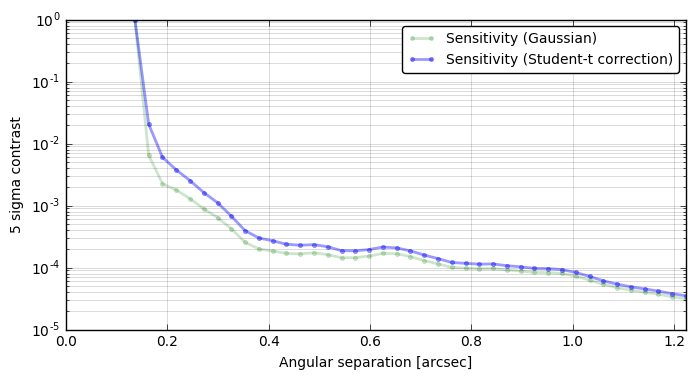

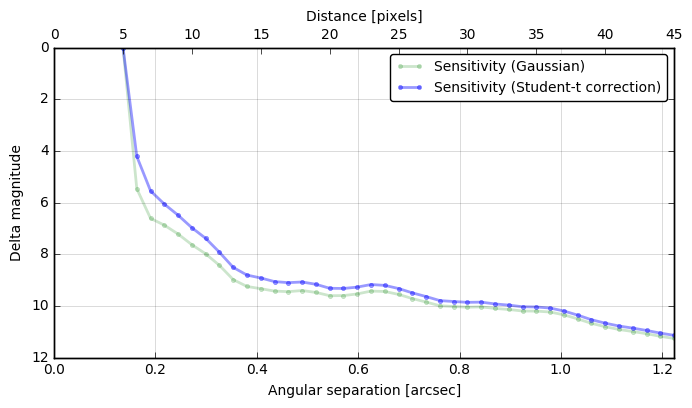

In [164]:
_ = vip.phot.contrast_curve(cube_emp, angs, psf, fwhm_naco, pxscale_naco, starphot, 
                            sigma=5, nbranch=1, algo=vip.pca.pca, ncomp=opt_pcs, debug=True)

[Go to the top](#Table-of-contents)